In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils
%aimport ocfeats


In [2]:
from pathlib import Path

import pandas as pd # also openpyxl for xlsx files
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import ConvexHull

from tqdm.auto import tqdm, trange

from utils import read_trc, read_mot
import ocfeats

# gdrive = Path('/Volumes/GoogleDrive-112026393729621442608')
gdrive = Path('/Users/psr/Library/CloudStorage/GoogleDrive-paru@stanford.edu')
datadir = gdrive / 'My Drive/NMBL Lab/OpenCap for NMD biomarkers/data'
dataset = '2023-05_dhd'

def get_trc_fpath(sid, trial):
    return datadir / dataset / f'opencap_data/{sid}/' \
        f'MarkerData/PostAugmentation/{trial}/{trial}.trc'

def get_mot_fpath(sid, trial):
    return datadir / dataset / f'opencap_data/{sid}/' \
        f'OpenSimData/Kinematics/{trial}.mot'
    

In [3]:
# colorblind friendly palette
from cycler import cycler
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
plt.rcParams['axes.prop_cycle'] = cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']

# automatically despine
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# set defualt DPI
plt.rcParams['figure.dpi'] = 72



In [4]:
df_session = pd.read_excel(datadir / dataset / 'session_info.xlsx', )
df_trial = pd.read_excel(datadir / dataset / 'trial_info.xlsx')
df_part = pd.read_excel(datadir / dataset / 'participant_info.xlsx')


p048


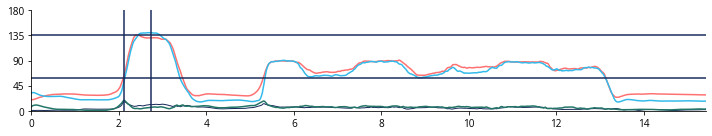

In [5]:
pid = 'p014'
# pid = 'p060'
# pid = 'p093'

df_temp = df_trial[df_trial.trial_clean == 'curls']
um = df_temp.sample(1).iloc[0]
pid, sid, trial = um[['pid', 'sid', 'trial']]
print(pid)

fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))

rw = xyz[:,np.argmax(markers=='RWrist'),1]
lw = xyz[:,np.argmax(markers=='LWrist'),1]
mean_w = (rw + lw) / 2

rsa, rea, lsa, lea = ocfeats.trc_arm_angles(xyz, markers)

mean_sa = (rsa + lsa) / 2
mean_ea = (rea + lea) / 2

max_rsa = np.max(rsa)
max_lsa = np.max(lsa)

max_mean_sa = np.max(mean_sa)

rea_at_max_rsa = rea[np.argmax(rsa)]
lea_at_max_lsa = lea[np.argmax(lsa)]
mean_ea_at_max_mean_sa = mean_ea[np.argmax(mean_sa)]

rea_at_max_rw = rea[np.argmax(rw)]
lea_at_max_lw = lea[np.argmax(lw)]
mean_ea_at_max_mean_w = mean_ea[np.argmax(mean_w)]

t = np.arange(xyz.shape[0]) / fps
plt.figure(figsize=(10,2))
plt.plot(t, rsa, lw=1)
plt.plot(t, rea)
plt.plot(t, lsa)
plt.plot(t, lea)
plt.axhline(mean_ea_at_max_mean_sa)
plt.axhline(mean_ea_at_max_mean_w)
plt.axvline(t[np.argmax(mean_sa)])
plt.axvline(t[np.argmax(mean_w)])
plt.xlim(t[0], t[-1])
plt.ylim(0, 180)
plt.yticks([0, 45, 90, 135, 180])
plt.tight_layout()
plt.show()


In [6]:
df_temp = df_trial[df_trial.trial_clean == 'curls']
data = []
for i, row in tqdm(df_temp.iterrows(), total=df_temp.shape[0]):
    pid, sid, trial = row[['pid', 'sid', 'trial']]
    # print(pid)

    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))

    rsa, rea, lsa, lea = ocfeats.trc_arm_angles(xyz, markers)
    max_rea = np.max(rea)
    max_lea = np.max(lea)
    mean_ea = (rea + lea) / 2
    max_mean_ea = np.max(mean_ea)
    
    data.append({'pid': pid,
                 'max_rea': max_rea,
                 'max_lea': max_lea,
                 'max_mean_ea': max_mean_ea,
                })


  0%|          | 0/88 [00:00<?, ?it/s]

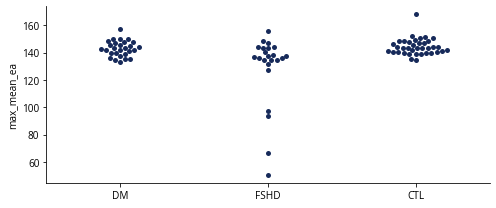

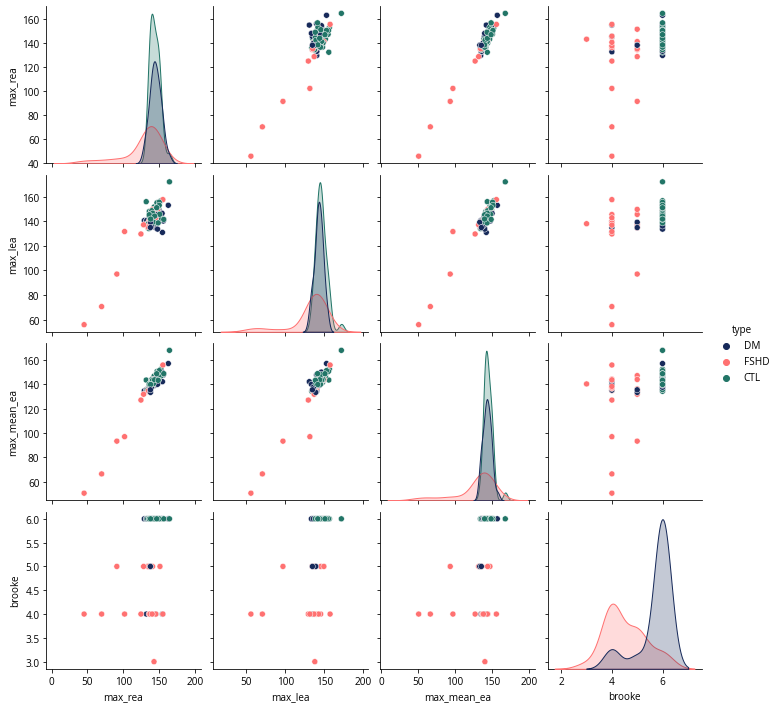

In [7]:
df_brooke = pd.DataFrame(data)
df_temp = df_brooke.merge(df_part[['pid', 'brooke', 'type']],
                          on='pid', how='left')

plt.figure(figsize=(7,3))
sns.swarmplot(df_temp, x='type', y='max_mean_ea')
plt.xlabel('')
sns.despine()
plt.tight_layout()
plt.show()

sns.pairplot(df_temp, hue='type')
plt.show()
